# Homework 3

Visualizing relationships between variables

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [163]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

## Loading 


In [164]:
%time brfss = pd.read_hdf('brfss.hdf5', 'brfss')

CPU times: user 8.37 ms, sys: 4.21 ms, total: 12.6 ms
Wall time: 12.1 ms


In [165]:
brfss.shape

(100000, 9)

In [166]:
brfss.head()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
96230,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
244920,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
57312,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
32573,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
355929,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


In [167]:
brfss.describe()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
count,99938.000000,95143.000000,93404.000000,83447.000000,100000.000000,98794.000000,87713.000000,95143.000000,98794.000000
mean,1.513809,170.090443,81.202017,5.788656,2785.881001,6.103296,1.926845,163.915369,47.720732
std,0.499812,10.795080,20.945679,2.229189,3982.612684,3.601652,1.290404,11.297379,18.873769
min,1.000000,91.000000,23.130000,1.000000,5.774036,1.000000,0.000000,90.000000,21.000000
25%,1.000000,163.000000,66.220000,4.000000,579.932564,3.000000,1.140000,160.000000,32.000000
50%,2.000000,170.000000,78.930000,6.000000,1378.138470,6.000000,1.700000,160.000000,47.000000
75%,2.000000,178.000000,90.720000,8.000000,3202.380370,9.000000,2.410000,170.000000,62.000000
max,2.000000,226.000000,272.610000,8.000000,45053.592700,13.000000,15.000000,220.000000,89.500000


## Scatter plot

Scatter plots are a good way to visualize the relationship between two variables, but it is surprising hard to make a good one.

Here's a simple plot of height and weight.

In [168]:
height = brfss['HTM4']
weight = brfss['WTKG3']

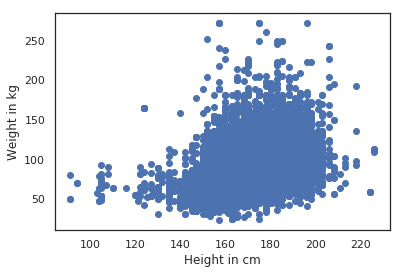

In [169]:
plt.plot(height, weight, 'o')

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg');

The center of this plot is saturated, so it is not as dark as it should be, which means the rest of the plot is relatively darker than it should be.  It gives too much visual weight to the outliers and obscures the shape of the relationship.

**Exercise:** Use keywords `alpha` and `markersize` to avoid saturation. 

Text(0, 0.5, 'Weight in kg')

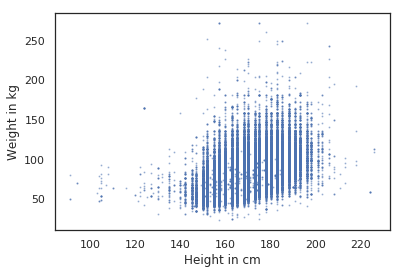

In [170]:
plt.plot(height, weight, 'o', alpha=0.4, markersize=1)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')

With transparency and smaller markers, you will be able to see that height and weight are discretized.

**Exercise:** Use `np.random.normal` to add enough noise to height and weight so the vertical lines in the scatter plot are blurred out.  Create variables named `height_jitter` and `weight_jitter`.

Text(0, 0.5, 'Weight in kg')

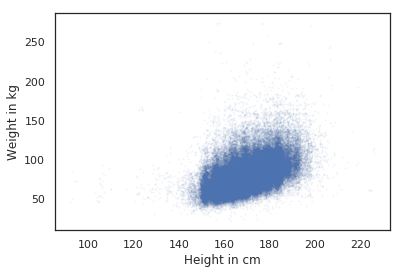

In [171]:
height_jitter = np.random.normal(0, height.std() * 0.1, height.shape) + height
weight_jitter = np.random.normal(0, weight.std() * 0.1, height.shape) + weight

plt.plot(height_jitter, weight_jitter, 'o', alpha=0.05, markersize=1)

plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')

## Linear regression

We can use `scipy.stats` to find the linear least squares fit to weight as a function of height.

In [172]:
from scipy.stats import linregress

subset = brfss.dropna(subset=['WTKG3', 'HTM4'])
xs = subset['HTM4']
ys = subset['WTKG3']

res = linregress(xs, ys)
res

LinregressResult(slope=0.9192115381848305, intercept=-75.12704250330248, rvalue=0.4742030897902462, pvalue=0.0, stderr=0.005632863769802998)

The `LinregressResult` object contains the estimated parameters and a few other statistics.

We can use the estimated `slope` and `intercept` to plot the line of best fit.

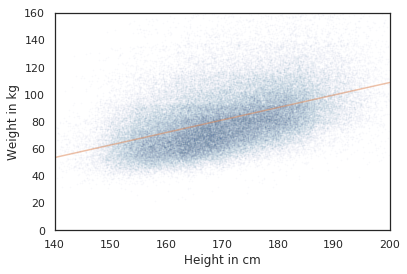

In [173]:
# jitter the data
height_jitter = height + np.random.normal(0, 2, size=len(height))
weight_jitter = weight + np.random.normal(0, 2, size=len(weight))

# make the scatter plot
plt.plot(height_jitter, weight_jitter, 'o', markersize=1, alpha=0.02)
plt.axis([140, 200, 0, 160])

# plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)

# label the axes
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.axis([140, 200, 0, 160]);

## Weight and age

**Exercise:** Make a scatter plot of weight and age.  The variable `AGE` is discretized in 5-year intervals, so you might want to jitter it.  

Adjust transparency and marker size to generate the best view of the relationship.

Text(0, 0.5, 'weight in kg')

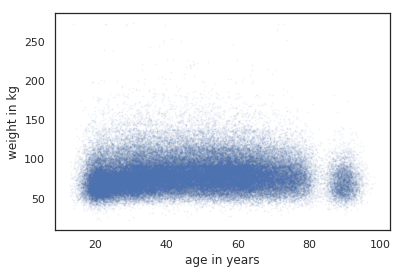

In [174]:
age = brfss['AGE']
age_jitter = np.random.normal(0, 2.5, size=age.shape) + age

plt.plot(age_jitter, weight_jitter, 'o', markersize=1, alpha=0.05)
plt.xlabel('age in years')
plt.ylabel('weight in kg')

**Exercise:** Use `linregress` to estimate the slope and intercept of the line of best fit for this data.

Note: as in the previous example, use `dropna` to drop rows that contain NaN for either variable, and use the resulting subset to compute the arguments for `linregress`.

In [175]:
subset = brfss.dropna(subset=['AGE', 'WTKG3'])
age = subset['AGE']
weight = subset['WTKG3']

slope, intercept, rvalue, pvalue, sterr = linregress(age_jitter, weight_jitter)

**Exercise:** Generate a plot that shows the estimated line and a scatter plot of the data.

Text(0, 0.5, 'weight in kg')

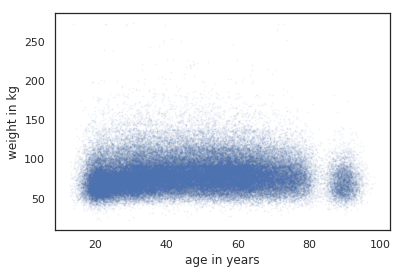

In [176]:
xs = np.array([age_jitter.min(), age_jitter.max()])
ys = xs * slope + intercept

plt.plot(age_jitter, weight_jitter, 'o', markersize=1, alpha=0.05)
plt.plot(xs, ys, '-', alpha = 0.5)
plt.xlabel('age in years')
plt.ylabel('weight in kg')

## Box and violin plots

The Seaborn package, which is usually imported as `sns`, provides two functions used to show the distribution of one variable as a function of another variable.

The following box plot shows the distribution of weight in each age category.  [Read the documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html) so you know what it means.

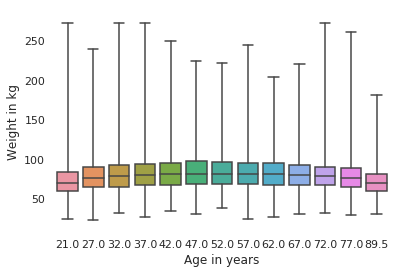

In [177]:
data = brfss.dropna(subset=['AGE', 'WTKG3'])

sns.boxplot(x='AGE', y='WTKG3', data=data, whis=10)

sns.despine(left=True, bottom=True)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg');

This figure makes the shape of the relationship clearer; average weight increases between ages 20 and 50, and then decreases.

A violin plot is another way to show the same thing.  Again, [read the documentation](https://seaborn.pydata.org/generated/seaborn.violinplot.html) so you know what it means.

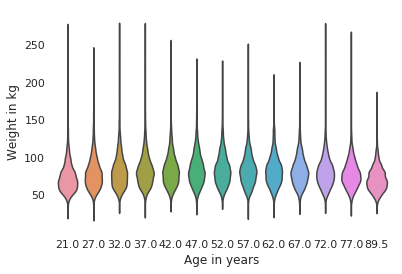

In [178]:
sns.violinplot(x='AGE', y='WTKG3', data=data, inner=None)

sns.despine(left=True, bottom=True)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg');

**Exercise:** Make a box plot that shows the distribution of weight as a function of income.  The variable `INCOME2` contains income codes with 8 levels.

Use `dropna` to select the rows with valid income and weight information.

Text(0, 0.5, 'Weight in kg')

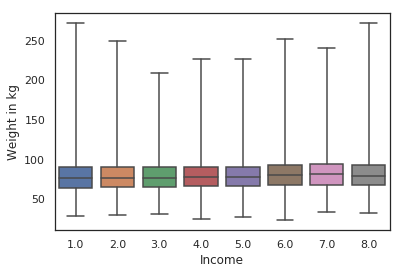

In [179]:
subset = brfss.dropna(subset=['INCOME2', 'WTKG3'])
sns.boxplot(x='INCOME2', y='WTKG3', data=subset, whis=10)
plt.xlabel('Income')
plt.ylabel('Weight in kg')

**Exercise:** Make a violin plot with the same variables.

Text(0, 0.5, 'Weight in kg')

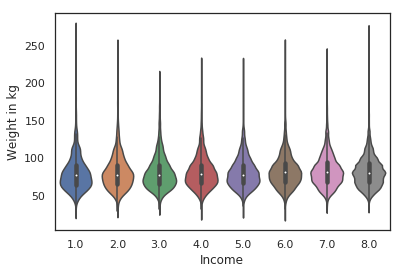

In [180]:
sns.violinplot(x='INCOME2', y='WTKG3', data=subset, whis=10)
plt.xlabel('Income')
plt.ylabel('Weight in kg')

## Plotting percentiles

One more way to show the relationship between two variables is to break one variables into groups and plot percentiles of the other variable across groups.

As a starting place, here's the median weight in each age group.

In [181]:
grouped = brfss.groupby('AGE')

for name, group in grouped['WTKG3']:
    print(name, group.median())

21.0 70.31
27.0 77.11
32.0 79.38
37.0 80.74
42.0 81.65
47.0 81.65
52.0 81.65
57.0 81.65
62.0 81.65
67.0 80.74
72.0 79.38
77.0 77.11
89.5 70.08


To get the other percentiles, we can use a `Cdf`.

In [182]:
ps = [95, 75, 50, 25, 5]

for name, group in grouped['WTKG3']:
    percentiles = Cdf(group).Percentiles(ps)
    print(name, percentiles)

21.0 [108.86  83.91  70.31  59.87  49.9 ]
27.0 [117.93  90.72  77.11  65.    52.62]
32.0 [122.47  92.99  79.38  65.77  54.43]
37.0 [122.47  94.35  80.74  68.04  56.25]
42.0 [122.47  95.25  81.65  68.04  55.34]
47.0 [124.74  97.52  81.65  69.4   55.79]
52.0 [123.38  96.62  81.65  68.95  55.79]
57.0 [117.93  95.25  81.65  68.49  54.43]
62.0 [122.47  95.25  81.65  68.04  54.43]
67.0 [117.93  92.99  80.74  68.04  54.43]
72.0 [113.4   90.72  79.38  68.04  53.52]
77.0 [111.13  89.81  77.11  65.77  52.16]
89.5 [99.79 81.65 69.85 59.87 49.44]


Now I'll collect those results in a list of arrays:

In [183]:
res = []
for name, group in grouped['WTKG3']:
    percentiles = Cdf(group).Percentiles(ps)
    res.append(percentiles)
    
res

[array([108.86,  83.91,  70.31,  59.87,  49.9 ]),
 array([117.93,  90.72,  77.11,  65.  ,  52.62]),
 array([122.47,  92.99,  79.38,  65.77,  54.43]),
 array([122.47,  94.35,  80.74,  68.04,  56.25]),
 array([122.47,  95.25,  81.65,  68.04,  55.34]),
 array([124.74,  97.52,  81.65,  69.4 ,  55.79]),
 array([123.38,  96.62,  81.65,  68.95,  55.79]),
 array([117.93,  95.25,  81.65,  68.49,  54.43]),
 array([122.47,  95.25,  81.65,  68.04,  54.43]),
 array([117.93,  92.99,  80.74,  68.04,  54.43]),
 array([113.4 ,  90.72,  79.38,  68.04,  53.52]),
 array([111.13,  89.81,  77.11,  65.77,  52.16]),
 array([99.79, 81.65, 69.85, 59.87, 49.44])]

To get the age groups, we can extract the "keys" from the groupby object.

In [184]:
xs = grouped.groups.keys()
xs

dict_keys([21.0, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0, 77.0, 89.5])

Now, we want to loop through the columns of the list of arrays; to do that, we want to transpose it.

In [185]:
rows = np.transpose(res)
rows

array([[108.86, 117.93, 122.47, 122.47, 122.47, 124.74, 123.38, 117.93,
        122.47, 117.93, 113.4 , 111.13,  99.79],
       [ 83.91,  90.72,  92.99,  94.35,  95.25,  97.52,  96.62,  95.25,
         95.25,  92.99,  90.72,  89.81,  81.65],
       [ 70.31,  77.11,  79.38,  80.74,  81.65,  81.65,  81.65,  81.65,
         81.65,  80.74,  79.38,  77.11,  69.85],
       [ 59.87,  65.  ,  65.77,  68.04,  68.04,  69.4 ,  68.95,  68.49,
         68.04,  68.04,  68.04,  65.77,  59.87],
       [ 49.9 ,  52.62,  54.43,  56.25,  55.34,  55.79,  55.79,  54.43,
         54.43,  54.43,  53.52,  52.16,  49.44]])

Now we can plot the percentiles across the groups.

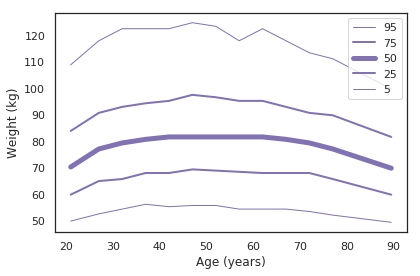

In [186]:
width = [1,2,5,2,1]

for i, qs in enumerate(rows):
    plt.plot(xs, qs, label=ps[i], linewidth=width[i], color='C4')
    
decorate(xlabel='Age (years)',
         ylabel='Weight (kg)')

In my opinion, this plot shows the shape of the relationship most clearly.

## Discretizing variables

Box plot, violin plots, and percentile line plots don't work as well if the number of groups on the x-axis is too big.  For example, here's a box plot of weight versus height.

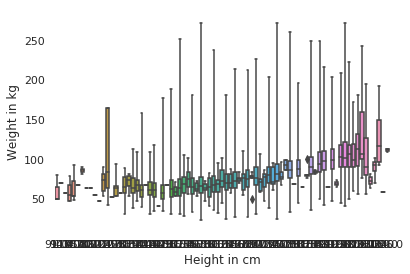

In [187]:
sns.boxplot(x='HTM4', y='WTKG3', data=data, whis=10)

sns.despine(left=True, bottom=True)
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg');

This would look better and mean more if there were fewer height groups.  We can use `pd.cut` to put people into height groups where each group spans 10 cm.

In [188]:
bins = np.arange(0, height.max(), 10)
brfss['_HTMG10'] = pd.cut(brfss['HTM4'], bins=bins, labels=bins[:-1]).astype(float)

Now here's what the plot looks like.

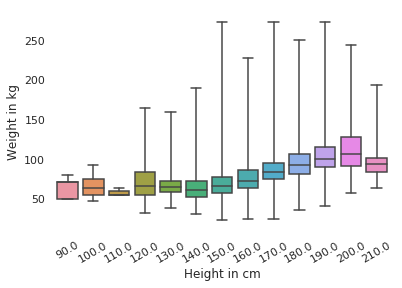

In [189]:
sns.boxplot(x='_HTMG10', y='WTKG3', data=brfss, whis=10)
plt.xticks(rotation=30)

sns.despine(left=True, bottom=True)
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg');

**Exercise:** Plot percentiles of weight versus these height groups.

In [190]:
grouped = brfss.groupby('_HTMG10')

for name, group in grouped['WTKG3']:
    print(name, group.median())

90.0 70.76
100.0 63.5
110.0 55.0
120.0 65.77
130.0 64.41
140.0 61.23
150.0 66.22
160.0 72.57
170.0 83.91
180.0 92.99
190.0 99.79
200.0 106.59
210.0 93.89


In [191]:
res = []
for name, group in grouped['WTKG3']:
    percentiles = Cdf(group).Percentiles(ps)
    res.append(percentiles)
    
res

[array([80.  , 70.76, 70.76, 49.9 , 49.9 ]),
 array([90.72, 77.11, 63.5 , 54.43, 47.63]),
 array([64., 64., 55., 55., 55.]),
 array([164.2 ,  83.46,  65.77,  54.43,  47.63]),
 array([95.25, 72.57, 63.96, 57.61, 43.09]),
 array([90.72, 72.57, 61.23, 52.16, 43.09]),
 array([99.79, 77.56, 66.22, 57.61, 48.08]),
 array([113.4 ,  86.18,  72.57,  63.5 ,  54.43]),
 array([119.29,  95.25,  83.91,  74.84,  62.6 ]),
 array([131.54, 106.59,  92.99,  81.65,  68.04]),
 array([145.15, 115.67,  99.79,  90.26,  74.39]),
 array([172.37, 129.27, 106.59,  90.72,  68.04]),
 array([192.78, 102.06,  92.53,  81.65,  63.96])]

In [192]:
xs = grouped.groups.keys()
rows = np.transpose(res)
rows

array([[ 80.  ,  90.72,  64.  , 164.2 ,  95.25,  90.72,  99.79, 113.4 ,
        119.29, 131.54, 145.15, 172.37, 192.78],
       [ 70.76,  77.11,  64.  ,  83.46,  72.57,  72.57,  77.56,  86.18,
         95.25, 106.59, 115.67, 129.27, 102.06],
       [ 70.76,  63.5 ,  55.  ,  65.77,  63.96,  61.23,  66.22,  72.57,
         83.91,  92.99,  99.79, 106.59,  92.53],
       [ 49.9 ,  54.43,  55.  ,  54.43,  57.61,  52.16,  57.61,  63.5 ,
         74.84,  81.65,  90.26,  90.72,  81.65],
       [ 49.9 ,  47.63,  55.  ,  47.63,  43.09,  43.09,  48.08,  54.43,
         62.6 ,  68.04,  74.39,  68.04,  63.96]])

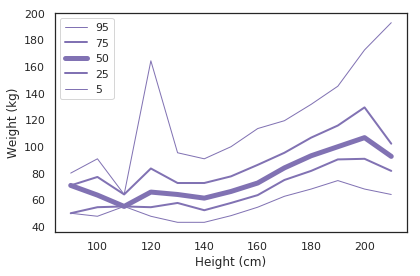

In [193]:
width = [1,2,5,2,1]

for i, qs in enumerate(rows):
    plt.plot(xs, qs, label=ps[i], linewidth=width[i], color='C4')
    
decorate(xlabel='Height (cm)',
         ylabel='Weight (kg)')

## Vegetables

**Exercise:** The variable `_VEGESU1` contains the self-reported number of serving of vegetables each respondent eats per day.  Explore relationships between this variable and the others variables in the dataset, and design visualizations that show any relationship you find as clearly as possible.

I have a feeling that age and weight might show the most interesting relationships with vegetable servings.

In [226]:
subset = brfss.dropna(subset=['AGE', '_VEGESU1', 'WTKG3'])
age = subset['AGE']
weight = subset['WTKG3']
veg = subset['_VEGESU1']

Veggies vs Age

Text(0, 0.5, 'Reported servings of vegetables per day')

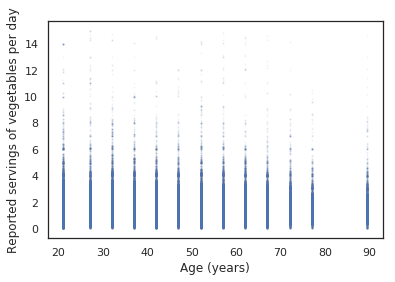

In [195]:
# Scatterplot.
plt.plot(age, veg, 'o', markersize=1, alpha=0.05)
plt.xlabel('Age (years)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

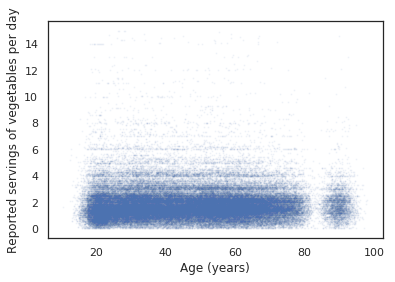

In [196]:
age_jitter = np.random.normal(0, 2.5, size=age.shape) + age

# Scatterplot with jittered age.
plt.plot(age_jitter, veg, 'o', markersize=1, alpha=0.05)
plt.xlabel('Age (years)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

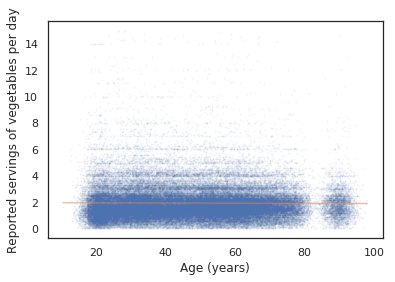

In [197]:
# Fit a line to the data.
slope, intercept, _, _, _ https://www.economist.com/briefing/2019/02/23/tens-of-thousands-of-americans-die-each-year-from-opioid-overdoses= linregress(age, veg)
xs = np.array([age_jitter.min(), age_jitter.max()])
ys = xs * slope + intercept

plt.plot(age_jitter, veg, 'o', markersize=1, alpha=0.05)
plt.plot(xs, ys, '-', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

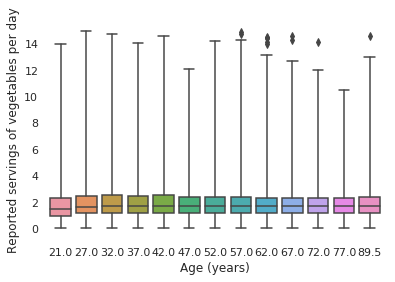

In [198]:
# Make a boxplot.
sns.boxplot(x='AGE', y='_VEGESU1', data=subset, whis=10)
sns.despine(left=True, bottom=True)
plt.xlabel('Age (years)')
plt.ylabel('Reported servings of vegetables per day')

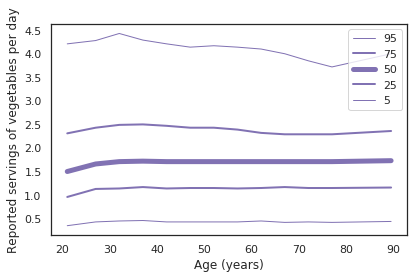

In [199]:
# Plot the percentiles.
grouped = brfss.groupby('AGE')
    
ps = [95, 75, 50, 25, 5]

res = []

for name, group in grouped['_VEGESU1']:
    percentiles = Cdf(group).Percentiles(ps)
    res.append(percentiles)

xs = grouped.groups.keys()

rows = np.transpose(res)

width = [1, 2, 5, 2, 1]

for i, qs in enumerate(rows):
    plt.plot(xs, qs, label=ps[i], linewidth=width[i], color='C4')
    
decorate(xlabel='Age (years)', ylabel="Reported servings of vegetables per day")

Veggies vs Weight

Text(0, 0.5, 'Reported servings of vegetables per day')

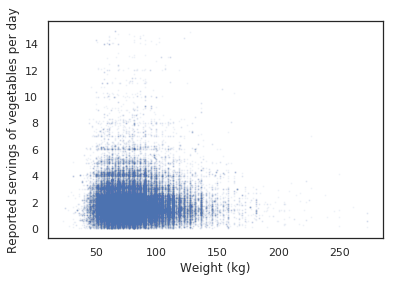

In [200]:
# Scatterplot.
plt.plot(weight, veg, 'o', markersize=1, alpha=0.05)
plt.xlabel('Weight (kg)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

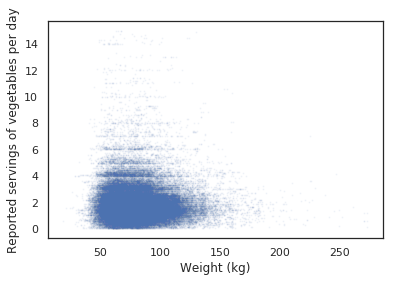

In [223]:
weight_jitter = np.random.normal(0, weight.std() * 0.1, size=weight.shape) + weight

# Scatterplot with jittered weight.
plt.plot(weight_jitter, veg, 'o', markersize=1, alpha=0.05)
plt.xlabel('Weight (kg)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

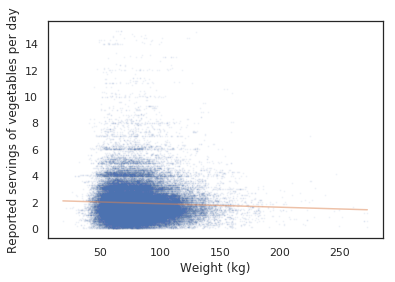

In [224]:
# Fit a line to the data.
slope, intercept, _, _, _ = linregress(weight, veg)
xs = np.array([weight_jitter.min(), weight_jitter.max()])
ys = xs * slope + intercept

plt.plot(weight_jitter, veg, 'o', markersize=1, alpha=0.05)
plt.plot(xs, ys, '-', alpha=0.5)
plt.xlabel('Weight (kg)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

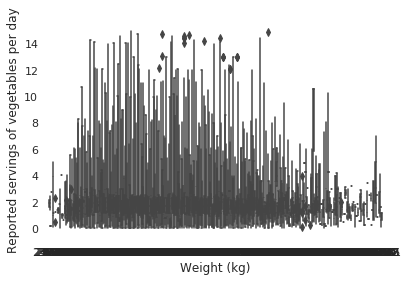

In [228]:
# Make a boxplot.
sns.boxplot(x='WTKG3', y='_VEGESU1', data=subset, whis=10)
sns.despine(left=True, bottom=True)
plt.xlabel('Weight (kg)')
plt.ylabel('Reported servings of vegetables per day')

Text(0, 0.5, 'Reported servings of vegetables per day')

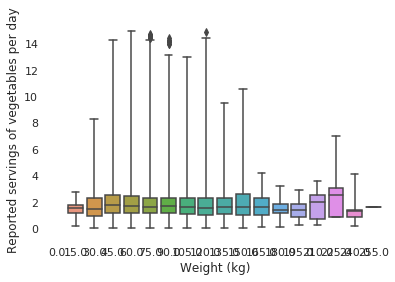

In [232]:
# Bins weights for a better boxplot.
bins = np.arange(0, weight.max(), 15)
brfss['_WTKG3'] = pd.cut(brfss['WTKG3'], bins=bins, labels=bins[:-1].astype(float))

sns.boxplot(x='_WTKG3', y='_VEGESU1', data=brfss, whis=10)
sns.despine(left=True, bottom=True)
plt.xlabel('Weight (kg)')
plt.ylabel('Reported servings of vegetables per day')

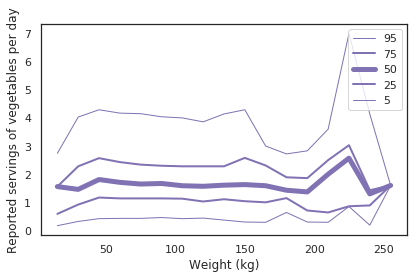

In [257]:
# Plot the percentiles.
subset = brfss.dropna(subset=['_WTKG3', '_VEGESU1'])
grouped = subset.groupby('_WTKG3')
    
ps = [95, 75, 50, 25, 5]

res = []

for name, group in grouped['_VEGESU1']:
    # The first group doesn't have a CDF.
    if Cdf(group):
        percentiles = Cdf(group).Percentiles(ps)
        res.append(percentiles)

xs = list(grouped.groups.keys())

# We have to get rid of the first group because it doesn't have a CDF.
xs = xs[1:]

rows = np.transpose(res)

width = [1, 2, 5, 2, 1]

for i, qs in enumerate(rows):
    plt.plot(xs, qs, label=ps[i], linewidth=width[i], color='C4')
    
decorate(xlabel='Weight (kg)', ylabel="Reported servings of vegetables per day")

## Correlation

One way to compute correlations is the Pandas method `corr`, which returns a correlation matrix.

In [201]:
subset = brfss[['HTM4', 'WTKG3', 'AGE']]
subset.corr()

,HTM4,WTKG3,AGE
HTM4,1.000000,0.474203,-0.093684
WTKG3,0.474203,1.000000,0.021641
AGE,-0.093684,0.021641,1.000000


**Exercise:** Compute a correlation matrix for age, income, and vegetable servings.

In [202]:
subset = brfss[['AGE', 'INCOME2', '_VEGESU1']]
subset.corr()

,AGE,INCOME2,_VEGESU1
AGE,1.000000,-0.015158,-0.009834
INCOME2,-0.015158,1.000000,0.119670
_VEGESU1,-0.009834,0.119670,1.000000


## Correlation calibration

To calibrate your sense of correlation, let's look at scatter plots for fake data with different values of `rho`.

The following function generates random normally-distributed data with approximately the given coefficient of correlation. 

In [203]:
def gen_corr(rho):
    means = [0, 0]
    covs = [[1, rho], [rho, 1]]
    m = np.random.multivariate_normal(means, covs, 100)
    return np.transpose(m)

This function makes a scatter plot and shows the actual value of `rho`.

In [204]:
def plot_scatter(rho, seed=1):
    np.random.seed(seed)
    xs, ys = gen_corr(rho)
    rho = np.corrcoef(xs, ys)[0][1]

    plt.plot(xs, ys, 'o', alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    ax = plt.gca()
    label_rho(ax, rho)
    
    return xs, ys

In [205]:
def label_rho(ax, rho):
    label = 'ρ = %0.2f' % rho
    plt.text(0.05, 0.95, label, 
             horizontalalignment='left', 
             verticalalignment='top', 
             transform=ax.transAxes,
             fontsize=12)

The following plots show what scatter plots look like with different values of `rho`.

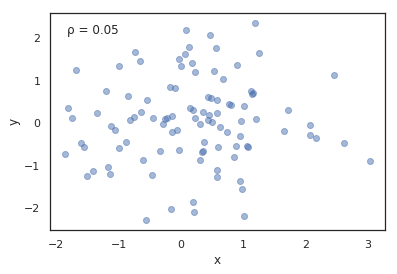

In [206]:
res = []
xs, ys = plot_scatter(0, seed=18)
res.append((xs, ys))

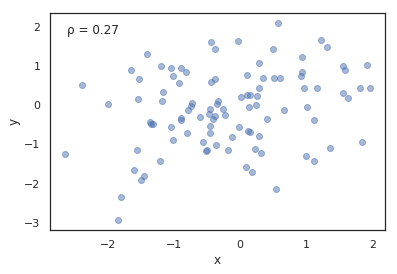

In [207]:
xs, ys = plot_scatter(0.25, seed=18)
res.append((xs, ys))

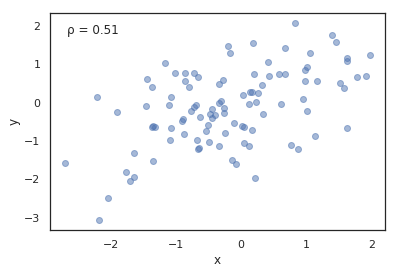

In [208]:
xs, ys = plot_scatter(0.5, seed=18)
res.append((xs, ys))

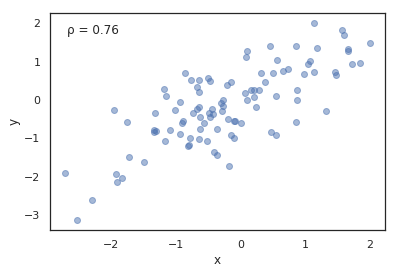

In [209]:
xs, ys = plot_scatter(0.75, seed=18)
res.append((xs, ys))

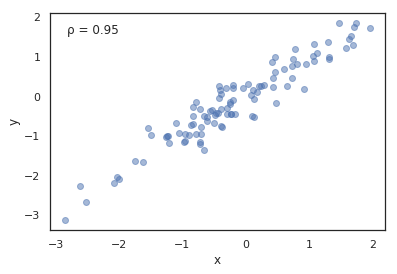

In [210]:
xs, ys = plot_scatter(0.95, seed=18)
res.append((xs, ys))

Here are all the plots side-by-side for comparison.

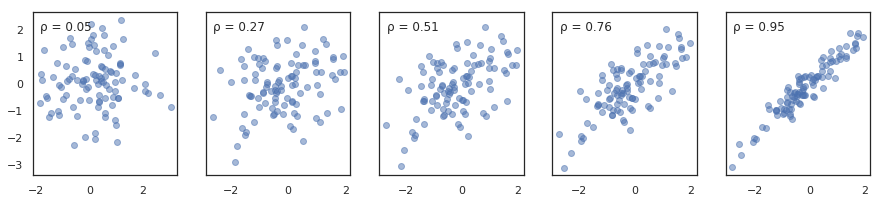

In [211]:
fig, axes = plt.subplots(ncols=5, sharey=True, figsize=(15,3)) 

for ax, (xs, ys) in zip(axes, res):
    ax.plot(xs, ys, 'o', alpha=0.5)
    rho = np.corrcoef(xs, ys)[0][1]
    label_rho(ax, rho)

## Nonlinear relationships

Here an example that generates fake data with a nonlinear relationship.

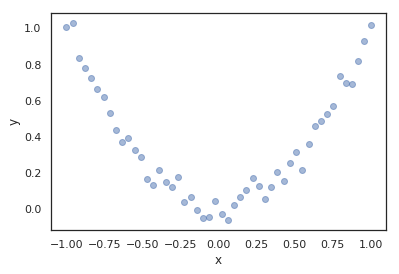

In [212]:
np.random.seed(18)
xs = np.linspace(-1, 1)
ys = xs**2 + np.random.normal(0, 0.05, len(xs))

plt.plot(xs, ys, 'o', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y');

This relationship is quite strong, in the sense that we can make a much better guess about `y` if we know `x` than if we don't.

But if we compute correlations, they don't show the relationship.

In [213]:
df = pd.DataFrame(dict(xs=xs, ys=ys))
df.corr(method='pearson')

,xs,ys
xs,1.000000,-0.011014
ys,-0.011014,1.000000


In [214]:
df.corr(method='spearman')

,xs,ys
xs,1.000000,-0.005234
ys,-0.005234,1.000000


In [215]:
df.corr(method='kendall')

,xs,ys
xs,1.000000,0.004082
ys,0.004082,1.000000


## Correlation strength

Here are two fake datasets showing hypothetical relationships between weight and age.

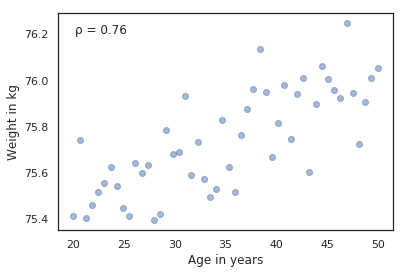

In [216]:
np.random.seed(18)
xs = np.linspace(20, 50)
ys1 = 75 + 0.02 * xs + np.random.normal(0, 0.15, len(xs))

plt.plot(xs, ys1, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')

rho = np.corrcoef(xs, ys1)[0][1]
label_rho(plt.gca(), rho)

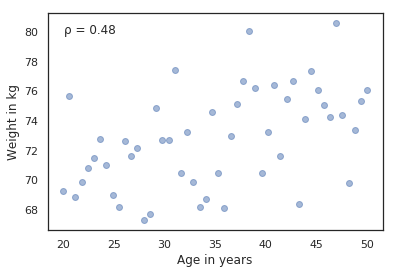

In [217]:
np.random.seed(18)
xs = np.linspace(20, 50)
ys2 = 65 + 0.2 * xs + np.random.normal(0, 3, len(xs))

plt.plot(xs, ys2, 'o', alpha=0.5)
plt.xlabel('Age in years')
plt.ylabel('Weight in kg')

rho = np.corrcoef(xs, ys2)[0][1]
label_rho(plt.gca(), rho)

Which relationship is stronger?

It depends on what we mean.  Clearly, the first one has a higher coefficient of correlation.  In that world, knowing someone's age would allow you to make a better guess about their weight.

But look more closely at the y-axis in the two plots.  How much weight do people gain per year in each of these hypothetical worlds?

In [218]:
from scipy.stats import linregress
        
res = linregress(xs, ys1)
res

LinregressResult(slope=0.018821034903244386, intercept=75.08049023710964, rvalue=0.7579660563439402, pvalue=1.8470158725246148e-10, stderr=0.002337849260560818)

In [219]:
res = linregress(xs, ys2)
res

LinregressResult(slope=0.17642069806488855, intercept=66.60980474219305, rvalue=0.47827769765763173, pvalue=0.0004430600283776241, stderr=0.04675698521121631)

In fact, the slope for the second data set is almost 10 times higher.

The following figures show the same data again, this time with the line of best fit and the estimated slope.

In [220]:
def label_slope(ax, slope):
    label = 'm = %0.3f' % slope
    plt.text(0.05, 0.95, label, 
             horizontalalignment='left', 
             verticalalignment='top', 
             transform=ax.transAxes,
             fontsize=12)

(75.35118093219263, 76.29172584257574)

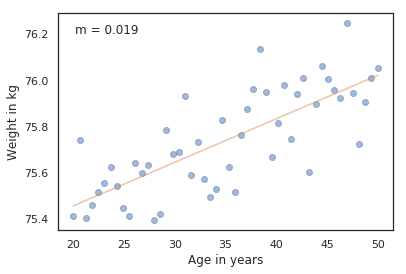

In [221]:
res = linregress(xs, ys1)
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx

plt.plot(xs, ys1, 'o', alpha=0.5)
plt.plot(fx, fy, '-', alpha=0.5)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
label_slope(plt.gca(), res.slope)

plt.gca().get_ylim()

(66.62157782752605, 81.25696583110674)

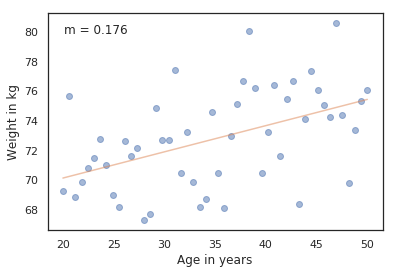

In [222]:
res = linregress(xs, ys2)
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx

plt.plot(xs, ys2, 'o', alpha=0.5)
plt.plot(fx, fy, '-', alpha=0.5)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
label_slope(plt.gca(), res.slope)

plt.gca().get_ylim()

The difference is not obvious from looking at the figure; you have to look carefully at the y-axis labels and the estimated slope.

And you have to interpret the slope in context.  In the first case, people gain about 0.019 kg per year, which works out to less than half a pound per decade.  In the second case, they gain almost 4 pounds per decade.

But remember that in the first case, the coefficient of correlation is substantially higher.

**Exercise:** So, in which case is the relationship "stronger"?  Write a sentence or two below to summarize your thoughts.

I would be more inclined to trust the data with a stronger linear correlation. This is because if the data is not strongly correlated, the linear slope wouldn't be as meaningful. I would probably want to run some simulations to see if the slope of the line is similar for multiple samples of the distribution. If it is highly variable, I would be less likely to trust it, but if the slope is about the same every time, I might say that the relationship is strong.